In [280]:
import sys
sys.path.append('../../')

from aml_project import utils
import biosppy.signals.ecg as ecg
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from scipy import signal
import numpy as np
import torch.nn as nn
from concurrent.futures import ProcessPoolExecutor
from functools import partial
import joblib
import ipyparallel as ipp

cpus = joblib.cpu_count() - 1

In [2]:
X_train, X_test, y_train = utils.load_df('data', 0)
X_train.head()

Loaded data successfully:
 - X_train	(5117, 17842)
 - X_test	(3411, 17842)
 - y_train	(5117, 1)


,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x17832,x17833,x17834,x17835,x17836,x17837,x17838,x17839,x17840,x17841
0,-64,-66,-69,-72,-75,-77,-80,-86,-89,-83,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,505,500,496,492,487,480,475,476,483,495,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-21,-16,-12,-7,-3,0,1,2,4,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-211,-457,-635,-710,-715,-663,-573,-481,-401,-337,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,36,32,29,25,22,19,17,15,12,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:ylabel='2'>

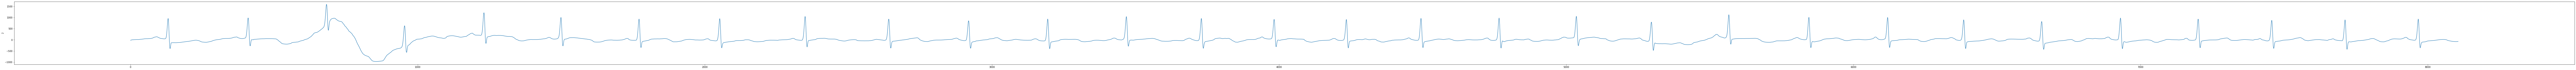

In [67]:
plt.figure(figsize=(200, 5))
sns.lineplot(y=X_train.iloc[2, :], x=range(X_train.shape[1]))

In [23]:
X_train.shape, X_train.iloc[:10].shape

((5117, 17842), (10, 17842))

In [198]:
sample = X_train.iloc[2, :]
rpeaks = ecg.engzee_segmenter(signal=sample, sampling_rate=300.0)['rpeaks']
heartbeats = ecg.extract_heartbeats(sample, rpeaks, sampling_rate=300)['templates']

<AxesSubplot:>

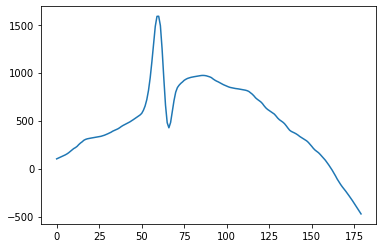

In [199]:
beat = heartbeats[2]
sns.lineplot(y=beat, x=range(heartbeats.shape[1]))

In [200]:
empty = np.empty((300, 180))
empty[:] = np.nan

In [201]:
np.append(heartbeats, empty, 0)

array([[  62.,   64.,   66., ...,  -93.,  -97.,  -99.],
       [  74.,   77.,   79., ..., -161., -171., -175.],
       [ 101.,  109.,  117., ..., -418., -445., -473.],
       ...,
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan]])

In [196]:
empty.shape

(300, 1)

In [189]:
heartbeats.shape

(30, 180)

In [279]:
class CWTTransform(TransformerMixin):
    def cwt(self, data):
        widths = np.arange(1, 101)
        return signal.cwt(data, signal.ricker, widths)

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return np.apply_along_axis(self.cwt, 1, X), y
    
class BeatSegmenter(TransformerMixin):
    def segment(self, signal, sampling_rate=300, nbeats=200, npoints=180):
        rpeaks = ecg.engzee_segmenter(signal, sampling_rate)['rpeaks']
        heartbeats = ecg.extract_heartbeats(signal, rpeaks, sampling_rate)['templates']
        fill_nan = np.empty((nbeats - heartbeats.shape[0], npoints))
        fill_nan[:] = np.nan
        heartbeats = np.append(heartbeats, fill_nan, 0)
        return heartbeats
    
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        heartbeats = np.apply_along_axis(self.segment, 1, X)
        return 
    

In [205]:
def segment(signal, sampling_rate=300, nbeats=200, npoints=180):
        rpeaks = ecg.engzee_segmenter(signal, sampling_rate)['rpeaks']
        heartbeats = ecg.extract_heartbeats(signal, rpeaks, sampling_rate)['templates']
        fill_nan = np.empty((nbeats - heartbeats.shape[0], npoints))
        fill_nan[:] = np.nan
        heartbeats = np.append(heartbeats, fill_nan, 0)
        return heartbeats

In [246]:
samples = X_train.iloc[:10, :]

numpy.ndarray

In [ ]:
pipe = 

In [213]:
%%time


CPU times: user 10.4 s, sys: 27.6 ms, total: 10.4 s
Wall time: 10.4 s


(100, 200, 180)

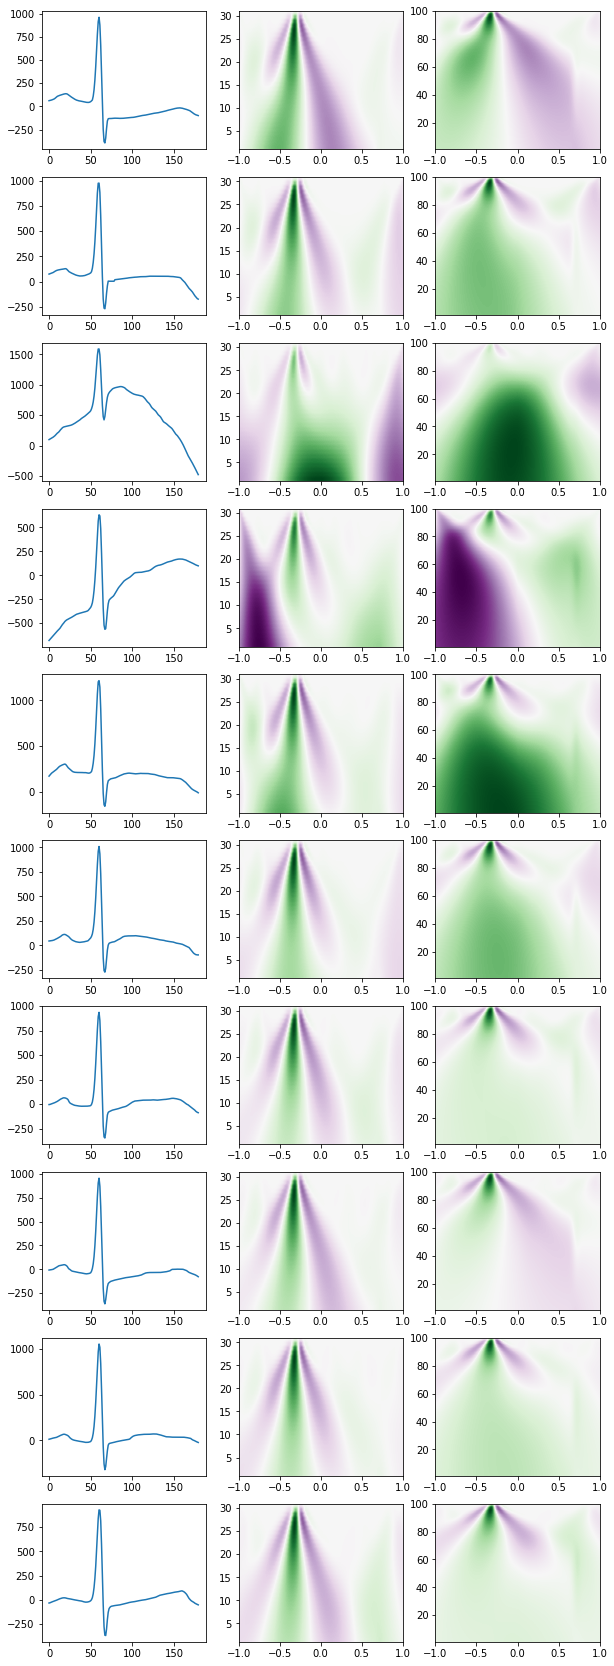

In [158]:
nrows = 10
ncols = 3
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 30))
axes = ax.flatten()
heartbeats_cwt = np.apply_along_axis(cwt, 1, heartbeats[:nrows])

for i in range(nrows):
    beat = heartbeats[i]
    widths = np.arange(1, 32)
    beat_cwt = signal.cwt(beat, signal.ricker, widths)
    sns.lineplot(x=range(len(beat)), y=beat, ax=axes[ncols*i])
    axes[ncols*i+1].imshow(beat_cwt, extent=[-1, 1, 1, 31], cmap='PRGn', aspect='auto', vmax=abs(beat_cwt).max(), vmin=-abs(beat_cwt).max())
    axes[ncols*i+2].imshow(heartbeats_cwt[i], extent=[-1, 1, 1, 100], cmap='PRGn', aspect='auto', vmax=abs(heartbeats_cwt[i]).max(), vmin=-abs(heartbeats_cwt[i]).max())

In [133]:
class MyModule(nn.Module):
    def __init__(self):
        super(MyModule, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 7)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.pooling1 = nn.MaxPool2d(5)
        self.pooling2 = nn.MaxPool2d(3)
        self.pooling3 = nn.AdaptiveMaxPool2d((1, 1))
        self.fc1 = nn.Linear(68, 32)
        self.fc2 = nn.Linear(32, 4)

    def forward(self, x1, x2):
        x1 = F.relu(self.bn1(self.conv1(x1)))  # (16 x 94 x 94)
        x1 = self.pooling1(x1)  # (16 x 18 x 18)
        x1 = F.relu(self.bn2(self.conv2(x1)))  # (32 x 16 x 16)
        x1 = self.pooling2(x1)  # (32 x 5 x 5)
        x1 = F.relu(self.bn3(self.conv3(x1)))  # (64 x 3 x 3)
        x1 = self.pooling3(x1)  # (64 x 1 x 1)
        x1 = x1.view((-1, 64))  # (64,)
        x = torch.cat((x1, x2), dim=1)  # (68,)
        x = F.relu(self.fc1(x))  # (32,)
        x = self.fc2(x)  # (4,)
        return x